In [1]:
##
# For debugging
##

import os
#os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = "1"

In [2]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import itertools
import requests, re, string, datetime, copy
from functools import partial
import copy
import os
from collections import defaultdict

import torch
import torchvision.transforms as T, torch.nn.functional as F, torch.nn as nn
from torch.utils.data import DataLoader

from datasets import Dataset

#to remove datasets outputs
import datasets
import logging
datasets.logging.get_verbosity = lambda: logging.NOTSET

from transformers import TrainingArguments, EarlyStoppingCallback, TrainerCallback, AutoTokenizer, AutoModelForSequenceClassification, Trainer, get_linear_schedule_with_warmup
from transformers import AutoTokenizer, AutoModel
from transformers.modeling_outputs import SequenceClassifierOutput

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, precision_recall_fscore_support, accuracy_score, f1_score
from sklearn.dummy import DummyClassifier

import plotly.graph_objects as go

from multiprocessing.pool import ThreadPool
from threading import Lock

PATH = "./data/"
MODEL_PATH = PATH + "models/"
device = "cuda:0"

##### preprocessing

In [4]:
class AlBERTo_Preprocessing(object):
    def __init__(self, do_lower_case=True, **kwargs):
        self.do_lower_case = do_lower_case
        self.text_processor = TextPreProcessor(
            # terms that will be normalized
            normalize=['url', 'email', 'user', 'percent', 'money', 'phone', 'time', 'date', 'number'],
            # terms that will be annotated
            annotate={"hashtag"},
            fix_html=True,  # fix HTML tokens
            unpack_hashtags=True,  # perform word segmentation on hashtags
            # select a tokenizer. You can use SocialTokenizer, or pass your own
            # the tokenizer, should take as input a string and return a list of tokens
            tokenizer=SocialTokenizer(lowercase=True).tokenize,
            dicts=[emoticons]
        )

    def preprocess(self, text):
        if self.do_lower_case:
            text = text.lower()
        text = str(" ".join(self.text_processor.pre_process_doc(text)))
        text = re.sub(r'[^a-zA-ZÀ-ú</>!?♥♡\s\U00010000-\U0010ffff]', ' ', text)
        text = re.sub(r'\s+', ' ', text)
        text = re.sub(r'(\w)\1{2,}', r'\1\1', text)
        text = re.sub(r'^\s', '', text)
        text = re.sub(r'\s$', '', text)
        return text

preprocess = AlBERTo_Preprocessing(do_lower_case=True)

/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Reading english - 1grams ...
Reading english - 2grams ...


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


Reading english - 1grams ...


##### models

In [5]:
tok_feelit = AutoTokenizer.from_pretrained("MilaNLProc/feel-it-italian-sentiment")
tok_feelit.model_max_length = 128

alberto = AutoModel.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
tok_alberto = AutoTokenizer.from_pretrained("m-polignano-uniba/bert_uncased_L-12_H-768_A-12_italian_alb3rt0")
tok_alberto.model_max_length = 128 #model.config.max_position_embeddings  

In [70]:
class AMC(nn.Module):
    def __init__(self):
        super(AMC, self).__init__()
        
        self.model = copy.deepcopy(alberto)
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()        
        self.hyper_params = {'learning_rate': 2e-5, 'warmup_steps': 0.1, 'weight_decay': 0.1, 'num_epochs': 3}            
        self.params_name = "alberto_multiclass.pt"

    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = self.dropout1(outputs[1])
        logits = self.linear1(x)
        loss = self.loss_fct(logits, labels)
        return logits , loss
    
class AMC_OPT(nn.Module):
    def __init__(self):
        super(AMC_OPT, self).__init__()
        
        self.model = copy.deepcopy(alberto)
        self.dropout1 = nn.Dropout(0.1)
        self.linear1 = nn.Linear(768, 3)

        self.loss_fct = nn.CrossEntropyLoss()
        self.hyper_params = {'learning_rate': 6.599917952321265e-05, 'weight_decay': 0.02157165894420757, 'warmup_steps': 0.8999999999999999, 'num_epochs': 11}
        self.params_name = "alberto_multiclass_opt_msmd.pt"

    def forward(self, labels, input_ids, attention_mask, **args):
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        x = self.dropout1(outputs[1])
        logits = self.linear1(x)
        loss = self.loss_fct(logits, labels)
        return logits , loss
    
    
class Feel_IT(nn.Module):
    def __init__(self, num_outputs, label_smoothing=None):
        super(Feel_IT, self).__init__()

        self.model = AutoModelForSequenceClassification.from_pretrained("MilaNLProc/feel-it-italian-sentiment")
        if num_outputs != 2:
            self.model.num_labels = num_outputs
            self.model.classifier.out_proj = nn.Linear(768, num_outputs)
        if label_smoothing is None:
            self.loss_fct = nn.CrossEntropyLoss()
        else:
            self.loss_fct = LabelSmoothingCrossEntropy(epsilon=label_smoothing)

    def forward(self, labels, input_ids, attention_mask, **args):
        #For the output format -> https://huggingface.co/transformers/_modules/transformers/models/bert/modeling_bert.html#BertForSequenceClassification.forward
        outputs = self.model(input_ids=input_ids, attention_mask=attention_mask, **args)
        if labels is None:
            loss = None
        else:
            loss = self.loss_fct(outputs.logits, labels)

        return SequenceClassifierOutput(
            loss=loss,
            logits=outputs.logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

#####  utility functions

In [8]:
def eval_feelit_model(dataset, 
                      keep_neutrals, 
                      dataset_name, 
                      logging=False, 
                      model_num_labels=3,
                      model_name="feel-it",
                      model_type="std",
                      validation_split=False):
    np.random.seed(0)
    torch.manual_seed(0)
    
    def MC2binary(e):
        #to convert the class label of positives from 2 into 1, when keep_neutrals=False and model_num_labels=2
        if not keep_neutrals:
            e["labels"] = e["labels"] if e["labels"] == 0 else 1
        return e

    model = Feel_IT(num_outputs=2).to(device)

    if keep_neutrals:
        testing = Dataset.from_pandas(dataset)\
                        .filter(lambda example: example['labels'] != 3)\
                        .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                        .with_format("torch", columns=["input_ids", "attention_mask", "labels"])
    else:
        testing = Dataset.from_pandas(dataset)\
                .map(lambda examples: tok_feelit(examples["text"], padding="max_length", truncation=True), batched=True)\
                .filter(lambda example: example['labels'] != 1)\
                .filter(lambda example: example['labels'] != 3)\
                .with_format("torch", columns=["input_ids", "attention_mask", "labels"])
    test_loader = DataLoader(testing, batch_size=64)


    model.eval()
    trues , preds , logitss = [] , [] , []
    with torch.no_grad():
        for _, data in enumerate(test_loader, 0):
            batch = {k: data[k].to(device) for k in ['attention_mask', 'input_ids']}
            logits = model(**batch, labels=None).logits
            trues.extend(data["labels"].detach().numpy())
            preds.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
            logitss.extend(logits.cpu().detach().numpy().tolist())
    
    trues , preds = np.array(trues) , np.array(preds)
    proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)
    num_assigned_to_neutral , num_correclty_assigned_to_neutral = 0 , 0
    for i in range(len(proba)):
        if keep_neutrals: # and not fine_tune and model_i is None:
            if preds[i] == 1: 
                preds[i] = 2
            if max(proba[i,0] , proba[i, 1]) <= 0.65: #set to neutral  if the prediction's confidence is too low
                preds[i] = 1
                num_assigned_to_neutral += 1
                if trues[i] == 1:
                    num_correclty_assigned_to_neutral += 1
        elif not keep_neutrals:
            if trues[i] == 2:
                trues[i] = 1

    targets = ["negative", "neutral", "positive"] if keep_neutrals else ["negative", "positive"]
    print(classification_report(trues, preds, target_names=targets))    
    
    global results, neutral_f1s
    tmp = " no neutral" if not keep_neutrals else ""
    tmp2 = " pretrained " + model_type
    results[dataset_name][model_name + tmp + tmp2] = f1_score(trues, preds, average="macro")
    dict_scores = classification_report(trues, preds, target_names=targets, output_dict=True)
    for l in targets:
        class_f1s[l][dataset_name][model_name + tmp + tmp2] = dict_scores[l]["f1-score"]
    
        
def train_epoch(model, train_loader, optimizer, scheduler, epoch, logging):
    model.train()
    targets , outputs = [] , []
    cumulative_loss = 0.
    for i , data in enumerate(train_loader, 0): 
        targets.extend(data["labels"].numpy())
        
        batch = {k: v.to(device) for k, v in data.items()}
        logits , loss = model(**batch)

        cumulative_loss += loss.detach()
        if (i+1) % 25 == 0 and logging:
            print(f'Epoch: {epoch}, Loss:  {cumulative_loss.item()/i}')
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
    return outputs, targets

def validation_epoch(model, epoch, val_loader):
    model.eval()
    logitss , targets , outputs = [] , []  , []
    with torch.no_grad():
        for i , data in enumerate(val_loader, 0):
            logits , _ = model(**{k: v.to(device) for k, v in data.items()})    
            targets.extend(data["labels"].cpu().detach().numpy())
            outputs.extend(logits.argmax(-1).cpu().detach().numpy().tolist())
            logitss.extend(logits.cpu().detach().numpy().tolist())
    return outputs, targets, logitss

def fine_tune_alberto(train_loader, val_loader, model, logging):
    hyper = model.hyper_params
    model.train()
        
    optimizer = torch.optim.AdamW(model.parameters(),
                                  lr=hyper["learning_rate"],
                                  weight_decay=hyper["weight_decay"], 
                                  eps=1e-6)
    num_epochs = hyper['num_epochs']
    num_train_steps = int(len(train_loader) * num_epochs) + 1
    num_warmup_steps =  int(num_train_steps * hyper["warmup_steps"])
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps, num_train_steps)
    
    best_value = 0    
    for epoch in range(num_epochs):
        outputs, targets = train_epoch(model, train_loader, optimizer, scheduler, epoch, logging)
        if logging: 
            f1_train = f1_score(targets, outputs, average='macro')
            print(f"Train F1 = {f1_train}")
        if val_loader is not None:
            outputs, targets, _ = validation_epoch(model, epoch, val_loader)
            f1_val = f1_score(targets, outputs, average='macro')
            if f1_val > best_value:
                best_value = f1_val
                best_model = copy.deepcopy(model)
                
    if val_loader is not None:
        return best_model
    else:
        return model        

def eval_alberto(model,  
                 dataset, 
                 dataset_name, 
                 keep_neutrals, 
                 fine_tuning=False, 
                 dataset_train=None, 
                 logging=False,  
                 model_init=None, 
                 validation_split=False,
                 suffix_model_name=""):
    np.random.seed(0)
    torch.manual_seed(0)
        
    torch_columns = ["input_ids", "attention_mask", "labels", "token_type_ids"]
    
    if keep_neutrals:
        testing = Dataset.from_pandas(dataset)\
                        .filter(lambda example: example['labels'] != 3)\
                        .map(lambda examples: tok_alberto(examples["text"], padding="max_length", truncation=True), batched=True)\
                        .with_format("torch", columns=torch_columns)
    else:
        testing = Dataset.from_pandas(dataset)\
                        .filter(lambda example: example['labels'] != 1)\
                        .filter(lambda example: example['labels'] != 3)\
                        .map(lambda examples: tok_alberto(examples["text"], padding="max_length", truncation=True), batched=True)\
                        .with_format("torch", columns=torch_columns)
    test_loader = DataLoader(testing, batch_size=32)
    
    if model_init is None:
        model = model().to(device)
        model.load_state_dict(torch.load(MODEL_PATH + model.params_name))
    else:
        model = model_init
        
    model_name = model.__class__.__name__ + " " + suffix_model_name
    tmp = " no neutrals" if not keep_neutrals else " "
    tmp2 = " fine tuned" if fine_tuning else " "
    print(model_name, tmp, tmp2, " --- ", dataset_name)    
    
    if fine_tuning:
        if type(validation_split) != type(True): #val dataset provided by the caller
            dataset_val = validation_split
            validation_split = True
        elif type(validation_split) == type(True) and validation_split == True: #create ad-hoc val split
            dataset_train, dataset_val = train_test_split(dataset_train, test_size=0.1, random_state=42, stratify=dataset_train["labels"])
        
        if not keep_neutrals:
            training = Dataset.from_pandas(dataset_train).filter(lambda example: example['labels'] != 1)
            if validation_split:
                validating = Dataset.from_pandas(dataset_val).filter(lambda example: example['labels'] != 1)
        else:
            training = Dataset.from_pandas(dataset_train)
            if validation_split:
                validating = Dataset.from_pandas(dataset_val)
            
        training = training.filter(lambda example: example['labels'] != 3).map(lambda examples: tok_alberto(examples["text"], padding="max_length", truncation=True), batched=True).with_format("torch", columns=torch_columns)
        train_loader = DataLoader(training, batch_size=64, shuffle=True)
        if validation_split:
            validating = validating.filter(lambda example: example['labels'] != 3).map(lambda examples: tok_alberto(examples["text"], padding="max_length", truncation=True), batched=True).with_format("torch", columns=torch_columns)
            val_loader = DataLoader(validating, batch_size=64, shuffle=False)
        else:
            val_loader = None 
        model = fine_tune_alberto(train_loader, val_loader, model, logging)

    model.eval()
    preds , trues, logitss = validation_epoch(model, None, test_loader)
    proba = torch.nn.functional.softmax(torch.tensor(logitss), dim=1)
    for i in range(len(preds)):
        if not keep_neutrals:
            if trues[i] == 2: 
                 trues[i] = 1
            if preds[i] == 1: #reassign prediction to second most-probable prediction
                preds[i] = np.argmax([proba[i][0], proba[i][2]])
            elif preds[i] == 2:
                preds[i] = 1                
                
    targets = ["negative", "neutral", "positive"] if keep_neutrals else ["negative", "positive"]
    print(classification_report(trues, preds, target_names=targets))
    
    global results, neutral_f1s
    results[dataset_name][model_name + tmp + tmp2] = f1_score(trues, preds, average="macro")
    dict_scores = classification_report(trues, preds, target_names=targets, output_dict=True)
    for l in targets:
        class_f1s[l][dataset_name][model_name + tmp + tmp2] = dict_scores[l]["f1-score"]
    
    if fine_tuning:
        return model
    
    
def eval_mfc_baseline(dataset_train, dataset_test, keep_neutrals):
    if not keep_neutrals:
        dataset_train = dataset_train[dataset_train.labels != 1]
        dataset_test = dataset_test[dataset_test.labels != 1]
    dataset_train = dataset_train[dataset_train.labels != 3]
    dataset_test = dataset_test[dataset_test.labels != 3]
    
    dummy_clf = DummyClassifier(strategy="stratified").fit(dataset_train.text, dataset_train.labels)
    preds = dummy_clf.predict(dataset_test.text)
    
    targets = ["negative", "neutral", "positive"] if keep_neutrals else ["negative", "positive"]
    print(classification_report(dataset_test.labels, preds, target_names=targets))

In [9]:
results = defaultdict(dict)
class_f1s = defaultdict(lambda: defaultdict(dict))

# SENTIPOLC16

In [10]:
def load_sentipolc():
    def separate2united_labels(row):
        if row["opos"] == 0 and row["oneg"] == 0:
            return 1
        elif row["oneg"] == 0 and row["opos"] == 1:
            return 2
        elif row["oneg"] == 1 and row["opos"] == 0:
            return 0
        else:
            return 3
        
    train = pd.read_csv(PATH + "Sentipolc16/training_set_sentipolc16.csv")
    
    #manually read test set with a formatting error
    file1 = open(PATH + "Sentipolc16/test_set_sentipolc16_gold2000.csv", 'r') 
    lines = file1.readlines()
    test = []
    for line in lines:
        arr = line.split("\",")
        if len(arr) != 9:
            arr[8] = arr[8] + arr[9]
            del arr[9:]
        for i in range(8):
            arr[i] = int(arr[i].strip("\""))
        test.append(arr)        
    test = pd.DataFrame(test, columns=train.columns)

    dataset_sentipolc_train = pd.DataFrame({"text": train.text.apply(preprocess.preprocess), "idx": train.index, "labels": train[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
    dataset_sentipolc_test  = pd.DataFrame({"text": test.text.apply(preprocess.preprocess), "idx": test.index, "labels": test[["opos", "oneg"]].apply(separate2united_labels, axis=1)})
    return dataset_sentipolc_train , dataset_sentipolc_test

dataset_name = "Sentipolc16"
dataset_sentipolc_train , dataset_sentipolc_test = load_sentipolc()

### Baselines

In [11]:
%%script echo skipping

##
# Prior-Label-Distribution classifier
##
print("\n\n PLD\n")
eval_mfc_baseline(dataset_sentipolc_train, dataset_sentipolc_test, keep_neutrals=True)

print("\n\n PLD\n")
eval_mfc_baseline(dataset_sentipolc_train, dataset_sentipolc_test, keep_neutrals=False)

skipping


### AMC/AMC opt

In [12]:
eval_alberto(AMC, dataset_sentipolc_test, dataset_name, keep_neutrals=True)
eval_alberto(AMC, dataset_sentipolc_test, dataset_name, keep_neutrals=False)

eval_alberto(AMC_OPT, dataset_sentipolc_test, dataset_name, keep_neutrals=True)
eval_alberto(AMC_OPT, dataset_sentipolc_test, dataset_name, keep_neutrals=False)

AMC       ---  Sentipolc16
              precision    recall  f1-score   support

    negative       0.85      0.51      0.64       734
     neutral       0.70      0.78      0.74       914
    positive       0.44      0.69      0.54       316

    accuracy                           0.67      1964
   macro avg       0.66      0.66      0.64      1964
weighted avg       0.71      0.67      0.67      1964

AMC   no neutrals    ---  Sentipolc16
              precision    recall  f1-score   support

    negative       0.95      0.70      0.81       734
    positive       0.57      0.92      0.71       316

    accuracy                           0.77      1050
   macro avg       0.76      0.81      0.76      1050
weighted avg       0.84      0.77      0.78      1050

AMC_OPT       ---  Sentipolc16
              precision    recall  f1-score   support

    negative       0.86      0.58      0.70       734
     neutral       0.69      0.89      0.78       914
    positive       0.62      0.57

### Feel-it

In [13]:
eval_feelit_model(dataset_sentipolc_test, keep_neutrals=True, dataset_name=dataset_name)
eval_feelit_model(dataset_sentipolc_test, keep_neutrals=False, dataset_name=dataset_name)

              precision    recall  f1-score   support

    negative       0.61      0.89      0.72       734
     neutral       0.61      0.01      0.02       914
    positive       0.29      0.79      0.42       316

    accuracy                           0.47      1964
   macro avg       0.50      0.56      0.39      1964
weighted avg       0.56      0.47      0.35      1964

              precision    recall  f1-score   support

    negative       0.91      0.89      0.90       734
    positive       0.76      0.80      0.78       316

    accuracy                           0.86      1050
   macro avg       0.83      0.85      0.84      1050
weighted avg       0.87      0.86      0.86      1050



# FEEL-IT dataset

In [14]:
def load_feelit():
    def emotion2sentiment(row):
        if row["label"] == "joy":
            return 2
        elif row["label"] == "sadness" or row["label"] == "fear" or row["label"] == "anger":
            return 0
    feel_it = pd.read_csv(PATH + "Feel-it/feelit.tsv", sep='\t', header=0, names=["text", "label"])
    return pd.DataFrame({"text": feel_it.text.apply(preprocess.preprocess), "idx": feel_it.index, "labels": feel_it[["label"]].apply(emotion2sentiment, axis=1)})

dataset_name = "Feel-it"
dataset_feel_it = load_feelit()

### AMC/AMC opt

In [16]:
eval_alberto(AMC, dataset_feel_it, dataset_name, keep_neutrals=False)
eval_alberto(AMC_OPT, dataset_feel_it, dataset_name, keep_neutrals=False)

AMC   no neutrals    ---  Feel-it
              precision    recall  f1-score   support

    negative       0.94      0.89      0.91      1309
    positive       0.82      0.90      0.86       728

    accuracy                           0.89      2037
   macro avg       0.88      0.89      0.89      2037
weighted avg       0.90      0.89      0.89      2037

AMC_OPT   no neutrals    ---  Feel-it
              precision    recall  f1-score   support

    negative       0.93      0.88      0.90      1309
    positive       0.80      0.87      0.84       728

    accuracy                           0.88      2037
   macro avg       0.87      0.88      0.87      2037
weighted avg       0.88      0.88      0.88      2037



### FEEL_IT model

In [17]:
eval_feelit_model(dataset_feel_it, keep_neutrals=False, dataset_name=dataset_name)

              precision    recall  f1-score   support

    negative       0.99      0.99      0.99      1309
    positive       0.97      0.99      0.98       728

    accuracy                           0.99      2037
   macro avg       0.98      0.99      0.99      2037
weighted avg       0.99      0.99      0.99      2037



# Amazon reviews

In [18]:
##
# To split the original dataset
##

# amazon = pd.read_json(PATH + "Amazon-reviews/Amazon_reviews_computer_cloths_food_shoaps.json")
# X_train, X_test = train_test_split(amazon, test_size=0.3, random_state=42, stratify=amazon["rating"])
# X_train.to_json(PATH + "Amazon-reviews/amazon_train.json")
# X_test.to_json(PATH + "Amazon-reviews/amazon_test.json")

In [19]:
def load_amazon():
    def rating2sentiment(row):
        if row["rating"] == 3:
            return 1
        elif row["rating"] > 3:
            return 2
        elif row["rating"] < 3:
            return 0
    amazon_train = pd.read_json(PATH + "Amazon-reviews/amazon_train.json")
    amazon_test = pd.read_json(PATH + "Amazon-reviews/amazon_test.json")

    amazon_train["text"] = amazon_train["title"] + ": " +  amazon_train["text"]
    amazon_test["text"] = amazon_test["title"] + ": " +  amazon_test["text"]
    
    dataset_amazon_train = pd.DataFrame({"text": amazon_train.text.apply(preprocess.preprocess), "idx": amazon_train.index, "labels": amazon_train[["rating"]].apply(rating2sentiment, axis=1)}) 
    dataset_amazon_test  = pd.DataFrame({"text": amazon_test.text.apply(preprocess.preprocess), "idx": amazon_test.index, "labels": amazon_test[["rating"]].apply(rating2sentiment, axis=1)}) 
    return dataset_amazon_train , dataset_amazon_test
    
dataset_name = "Amazon reviews"
dataset_amazon_train , dataset_amazon_test = load_amazon()

### Baselines

In [20]:
%%script echo skipping

##
# Prior-Label-Distribution classifier
##
print("\n\n PLD\n")
eval_mfc_baseline(dataset_amazon_train, dataset_amazon_test, keep_neutrals=True)

print("\n\n PLD no neutrals\n")
eval_mfc_baseline(dataset_amazon_train, dataset_amazon_test, keep_neutrals=False)

skipping


### AMC/AMC opt

In [21]:
eval_alberto(AMC, dataset_amazon_test, dataset_name, keep_neutrals=True)
eval_alberto(AMC_OPT, dataset_amazon_test, dataset_name, keep_neutrals=True)

eval_alberto(AMC, dataset_amazon_test, dataset_name, keep_neutrals=False)
eval_alberto(AMC_OPT, dataset_amazon_test, dataset_name, keep_neutrals=False)

AMC       ---  Amazon reviews
              precision    recall  f1-score   support

    negative       0.39      0.75      0.51        75
     neutral       0.08      0.11      0.09        38
    positive       0.90      0.60      0.72       239

    accuracy                           0.58       352
   macro avg       0.46      0.48      0.44       352
weighted avg       0.70      0.58      0.61       352

AMC_OPT       ---  Amazon reviews
              precision    recall  f1-score   support

    negative       0.54      0.73      0.62        75
     neutral       0.13      0.05      0.08        38
    positive       0.84      0.83      0.84       239

    accuracy                           0.72       352
   macro avg       0.51      0.54      0.51       352
weighted avg       0.70      0.72      0.71       352

AMC   no neutrals    ---  Amazon reviews
              precision    recall  f1-score   support

    negative       0.47      0.89      0.61        75
    positive       0.95 

### AMC opt fine tuned

In [22]:
eval_alberto(AMC_OPT, 
             dataset_amazon_test, 
             dataset_name, 
             keep_neutrals=True, 
             fine_tuning=True, 
             dataset_train=dataset_amazon_train,
             validation_split=True);

eval_alberto(AMC_OPT,  
             dataset_amazon_test, 
             dataset_name, 
             keep_neutrals=False, 
             fine_tuning=True, 
             dataset_train=dataset_amazon_train,
             validation_split=True);

AMC_OPT     fine tuned  ---  Amazon reviews
              precision    recall  f1-score   support

    negative       0.80      0.65      0.72        75
     neutral       0.30      0.32      0.31        38
    positive       0.89      0.94      0.91       239

    accuracy                           0.81       352
   macro avg       0.67      0.64      0.65       352
weighted avg       0.81      0.81      0.81       352

AMC_OPT   no neutrals  fine tuned  ---  Amazon reviews
              precision    recall  f1-score   support

    negative       0.90      0.75      0.82        75
    positive       0.92      0.97      0.95       239

    accuracy                           0.92       314
   macro avg       0.91      0.86      0.88       314
weighted avg       0.92      0.92      0.92       314



### Feel-IT

In [23]:
eval_feelit_model(dataset_amazon_test, keep_neutrals=True, dataset_name=dataset_name)
eval_feelit_model(dataset_amazon_test, keep_neutrals=False, dataset_name=dataset_name)

              precision    recall  f1-score   support

    negative       0.50      0.88      0.63        75
     neutral       0.00      0.00      0.00        38
    positive       0.92      0.83      0.87       239

    accuracy                           0.75       352
   macro avg       0.47      0.57      0.50       352
weighted avg       0.73      0.75      0.73       352

              precision    recall  f1-score   support

    negative       0.63      0.88      0.74        75
    positive       0.96      0.84      0.90       239

    accuracy                           0.85       314
   macro avg       0.80      0.86      0.82       314
weighted avg       0.88      0.85      0.86       314



---
# MultiEmotions-it

In [24]:
##
# To split the dataset, one split, read the directly the 2 files
##
# me_train = pd.read_csv(PATH + "Multiemotions-it/Multiemotions-it.tsv", sep='\t')
# me_train["labels"] = me_train[["POS", "NEG", "NEUT"]].apply(separate2united_labels, axis=1)

# X_train, X_test = train_test_split(me_train, test_size=0.15, random_state=42, stratify=me_train["labels"])
# X_train.to_csv(PATH + "Multiemotions-it/Multiemotions-it_train.tsv", sep='\t', index=False)
# X_test.to_csv(PATH + "Multiemotions-it/Multiemotions-it_test.tsv", sep='\t', index=False)

In [25]:
def load_multiemotions():
    def separate2united_labels(row):
        if row["POS"] == 0 and row["NEG"] == 0 and row["NEUT"] == 1:
            return 1
        elif row["NEG"] == 0 and row["POS"] == 1:
            return 2
        elif row["NEG"] == 1 and row["POS"] == 0:
            return 0
        else:
            return 3
    me_train = pd.read_csv(PATH + "Multiemotions-it/Multiemotions-it_train.tsv", sep='\t')
    me_test = pd.read_csv(PATH + "Multiemotions-it/Multiemotions-it_test.tsv", sep='\t')

    me_train["text"] = me_train["comment"] 
    me_test["text"] = me_test["comment"]

    me_train.drop(['type', 'title', 'URL', 'comment', 'UNRELATED', 'NEUT', 'POS', 'NEG',
                   'GIOIA', 'FIDUCIA', 'TRISTEZZA', 'RABBIA', 'PAURA', 'DISGUSTO',
                   'SORPRESA', 'TREPIDAZIONE', 'SARCASM', 'EMOTIONS',], axis=1, inplace=True)
    me_test.drop(['type', 'title', 'URL', 'comment', 'UNRELATED', 'NEUT', 'POS', 'NEG',
                   'GIOIA', 'FIDUCIA', 'TRISTEZZA', 'RABBIA', 'PAURA', 'DISGUSTO',
                   'SORPRESA', 'TREPIDAZIONE', 'SARCASM', 'EMOTIONS',], axis=1, inplace=True)

    dataset_me_train = pd.DataFrame({"text": me_train.text.apply(preprocess.preprocess), "idx": me_train.index, "labels": me_train["labels"].tolist()}) 
    dataset_me_test  = pd.DataFrame({"text": me_test.text.apply(preprocess.preprocess), "idx": me_test.index, "labels": me_test["labels"].tolist()}) 
    return dataset_me_train, dataset_me_test

dataset_name = "MultiEmotions-IT"
dataset_me_train, dataset_me_test = load_multiemotions()

### Baselines

In [26]:
%%script echo skipping

##
# Prior-Label-Distribution classifier
##
print("\n\n PLD\n")
eval_mfc_baseline(dataset_me_train, dataset_me_test, keep_neutrals=True)

print("\n\n PLD\n")
eval_mfc_baseline(dataset_me_train, dataset_me_test, keep_neutrals=False)

skipping


### AMC/ AMC opt

In [27]:
eval_alberto(AMC, dataset_me_test, dataset_name, keep_neutrals=True)
eval_alberto(AMC_OPT, dataset_me_test, dataset_name, keep_neutrals=True)

eval_alberto(AMC, dataset_me_test, dataset_name, keep_neutrals=False)
eval_alberto(AMC_OPT, dataset_me_test, dataset_name, keep_neutrals=False)

AMC       ---  MultiEmotions-IT
              precision    recall  f1-score   support

    negative       0.59      0.71      0.64       115
     neutral       0.39      0.64      0.48        44
    positive       0.96      0.78      0.86       288

    accuracy                           0.75       447
   macro avg       0.64      0.71      0.66       447
weighted avg       0.81      0.75      0.77       447

AMC_OPT       ---  MultiEmotions-IT
              precision    recall  f1-score   support

    negative       0.68      0.65      0.66       115
     neutral       0.39      0.73      0.50        44
    positive       0.94      0.83      0.88       288

    accuracy                           0.77       447
   macro avg       0.67      0.74      0.68       447
weighted avg       0.82      0.77      0.79       447

AMC   no neutrals    ---  MultiEmotions-IT
              precision    recall  f1-score   support

    negative       0.66      0.90      0.76       115
    positive      

#### AMC opt fine-tuned

In [28]:
eval_alberto(AMC_OPT,
             dataset_me_test, 
             dataset_name,
             keep_neutrals=True, 
             fine_tuning=True, 
             dataset_train=dataset_me_train,
             validation_split=True);

eval_alberto(AMC_OPT,
             dataset_me_test, 
             dataset_name,
             keep_neutrals=False, 
             fine_tuning=True, 
             dataset_train=dataset_me_train,
             validation_split=True);

AMC_OPT     fine tuned  ---  MultiEmotions-IT
              precision    recall  f1-score   support

    negative       0.74      0.79      0.76       115
     neutral       0.54      0.48      0.51        44
    positive       0.92      0.91      0.91       288

    accuracy                           0.83       447
   macro avg       0.73      0.72      0.73       447
weighted avg       0.83      0.83      0.83       447

AMC_OPT   no neutrals  fine tuned  ---  MultiEmotions-IT
              precision    recall  f1-score   support

    negative       0.92      0.72      0.81       115
    positive       0.90      0.98      0.94       288

    accuracy                           0.90       403
   macro avg       0.91      0.85      0.87       403
weighted avg       0.90      0.90      0.90       403



### Feel-IT - MultiEmotions-IT

In [29]:
eval_feelit_model(dataset_me_test, keep_neutrals=True, dataset_name=dataset_name)
eval_feelit_model(dataset_me_test, keep_neutrals=False, dataset_name=dataset_name)

              precision    recall  f1-score   support

    negative       0.50      0.90      0.64       115
     neutral       0.00      0.00      0.00        44
    positive       0.88      0.72      0.79       288

    accuracy                           0.70       447
   macro avg       0.46      0.54      0.48       447
weighted avg       0.70      0.70      0.68       447

              precision    recall  f1-score   support

    negative       0.57      0.90      0.70       115
    positive       0.95      0.72      0.82       288

    accuracy                           0.77       403
   macro avg       0.76      0.81      0.76       403
weighted avg       0.84      0.77      0.78       403



# AriEmozione

In [30]:
def load_ari():
    def emotion2label(row):
        if row["labels"] in ["Gioia", "Ammirazione", "Amore"]:
            return 2
        elif row["labels"] in ["Rabbia", "Tristezza", "Paura"]:
            return 0
        else:
            return 1
    ari_train = pd.read_csv(PATH + "Aria/ariaset_train.tsv", sep='\t', encoding="latin-1", names=["names", "text", "labels", "confidence", "?"])
    ari_train.drop(["?", "names"], axis=1, inplace=True)
    ari_train.dropna(inplace=True)

    ari_test = pd.read_csv(PATH + "Aria/ariaset_test.tsv", sep='\t', encoding="latin-1", names=["names", "text", "labels", "confidence", "?"])
    ari_test.drop(["?", "names"], axis=1, inplace=True)
    ari_test.dropna(inplace=True)

    ari_val = pd.read_csv(PATH + "Aria/ariaset_dev.tsv", sep='\t', encoding="latin-1", names=["names", "text", "labels", "confidence", "?"])
    ari_val.drop(["?", "names"], axis=1, inplace=True)
    ari_val.dropna(inplace=True)

    dataset_ari_train = pd.DataFrame({"text": ari_train.text.apply(preprocess.preprocess), "idx": ari_train.index, "labels": ari_train[["labels"]].apply(emotion2label, axis=1)}) 
    dataset_ari_test = pd.DataFrame({"text": ari_test.text.apply(preprocess.preprocess), "idx": ari_test.index, "labels": ari_test[["labels"]].apply(emotion2label, axis=1)}) 
    dataset_ari_val = pd.DataFrame({"text": ari_val.text.apply(preprocess.preprocess), "idx": ari_val.index, "labels": ari_val[["labels"]].apply(emotion2label, axis=1)}) 
    return dataset_ari_train, dataset_ari_test, dataset_ari_val

dataset_name = "AriEmotions"
dataset_ari_train, dataset_ari_test, dataset_ari_val = load_ari()

### Baselines

In [31]:
%%script echo skipping
##
# Prior-Label-Distribution classifier
##
print("\n\n PLD\n")
eval_mfc_baseline(dataset_ari_train, dataset_ari_test, keep_neutrals=False)

skipping


### AlBERTo MC/opt - AriEmotions

In [32]:
eval_alberto(AMC, dataset_ari_test, dataset_name, keep_neutrals=True)
eval_alberto(AMC, dataset_ari_test, dataset_name, keep_neutrals=False)

eval_alberto(AMC_OPT, dataset_ari_test, dataset_name, keep_neutrals=True)
eval_alberto(AMC_OPT, dataset_ari_test, dataset_name, keep_neutrals=False)

AMC       ---  AriEmotions
              precision    recall  f1-score   support

    negative       0.67      0.69      0.68       133
     neutral       0.11      0.73      0.19        11
    positive       0.76      0.27      0.40       106

    accuracy                           0.52       250
   macro avg       0.51      0.56      0.42       250
weighted avg       0.68      0.52      0.54       250

AMC   no neutrals    ---  AriEmotions
              precision    recall  f1-score   support

    negative       0.64      0.86      0.73       133
    positive       0.69      0.38      0.49       106

    accuracy                           0.65       239
   macro avg       0.66      0.62      0.61       239
weighted avg       0.66      0.65      0.62       239

AMC_OPT       ---  AriEmotions
              precision    recall  f1-score   support

    negative       0.73      0.56      0.64       133
     neutral       0.11      0.82      0.19        11
    positive       0.71      0.42

### AMC opt fine tuned

In [33]:
eval_alberto(AMC_OPT,
             dataset_ari_test, 
             dataset_name, 
             keep_neutrals=True, 
             fine_tuning=True, 
             dataset_train=dataset_ari_train,
             validation_split=dataset_ari_val
            );

eval_alberto(AMC_OPT,
             dataset_ari_test, 
             dataset_name, 
             keep_neutrals=False, 
             fine_tuning=True, 
             dataset_train=dataset_ari_train,
             validation_split=dataset_ari_val
            );

AMC_OPT     fine tuned  ---  AriEmotions
              precision    recall  f1-score   support

    negative       0.77      0.74      0.76       133
     neutral       0.88      0.64      0.74        11
    positive       0.68      0.73      0.70       106

    accuracy                           0.73       250
   macro avg       0.77      0.70      0.73       250
weighted avg       0.74      0.73      0.73       250

AMC_OPT   no neutrals  fine tuned  ---  AriEmotions
              precision    recall  f1-score   support

    negative       0.80      0.73      0.76       133
    positive       0.69      0.76      0.73       106

    accuracy                           0.74       239
   macro avg       0.74      0.75      0.74       239
weighted avg       0.75      0.74      0.75       239



### Feel-it model - AriEmotions

In [34]:
eval_feelit_model(dataset_ari_test, keep_neutrals=True, dataset_name=dataset_name)
eval_feelit_model(dataset_ari_test, keep_neutrals=False, dataset_name=dataset_name)

              precision    recall  f1-score   support

    negative       0.61      0.90      0.73       133
     neutral       0.00      0.00      0.00        11
    positive       0.74      0.33      0.46       106

    accuracy                           0.62       250
   macro avg       0.45      0.41      0.40       250
weighted avg       0.64      0.62      0.58       250

              precision    recall  f1-score   support

    negative       0.64      0.91      0.75       133
    positive       0.76      0.36      0.49       106

    accuracy                           0.67       239
   macro avg       0.70      0.63      0.62       239
weighted avg       0.69      0.67      0.63       239



---
# Trip-maml

In [35]:
def load_tripmaml():
    def segments2text(row):
        return " ".join([ e.split("/")[0] for sub_segment in row["segments"] for e in sub_segment.split(" ")]) 

    def rating2sentiment(row):
        if row["ratingOverall"] == 3:
            return 1
        elif row["ratingOverall"] > 3:
            return 2
        elif row["ratingOverall"] < 3:
            return 0

    trip_train = pd.read_json(PATH + "Trip-maml/italian_training.json", lines=True)
    dataset_trip_train = pd.DataFrame({"text": trip_train[["segments"]].apply(segments2text, axis=1).apply(preprocess.preprocess), "idx": trip_train.index, "labels": trip_train[["ratingOverall"]].apply(rating2sentiment, axis=1)}) 

    trip_test = pd.read_json(PATH + "Trip-maml/italian_test.json", lines=True)
    dataset_trip_test = pd.DataFrame({"text": trip_test[["segments"]].apply(segments2text, axis=1).apply(preprocess.preprocess), "idx": trip_test.index, "labels": trip_test[["ratingOverall"]].apply(rating2sentiment, axis=1)}) 
    return dataset_trip_train, dataset_trip_test

dataset_name = "Trip-maml"
dataset_trip_train, dataset_trip_test = load_tripmaml()

### Baselines

In [36]:
%%script echo skipping

##
# Prior-Label-Distribution classifier
##
print("\n\n SMFC\n")
eval_mfc_baseline(dataset_trip_train, dataset_trip_test, keep_neutrals=True)

print("\n\n SMFC no neutrals\n")
eval_mfc_baseline(dataset_trip_train, dataset_trip_test, keep_neutrals=False)

skipping


### AMC/AMC opt

In [37]:
eval_alberto(AMC, dataset_trip_test, dataset_name, keep_neutrals=True)
eval_alberto(AMC_OPT, dataset_trip_test, dataset_name, keep_neutrals=True)

eval_alberto(AMC, dataset_trip_test, dataset_name, keep_neutrals=False)
eval_alberto(AMC_OPT, dataset_trip_test, dataset_name, keep_neutrals=False)

AMC       ---  Trip-maml
              precision    recall  f1-score   support

    negative       0.35      0.94      0.51        17
     neutral       0.20      0.05      0.08        20
    positive       0.95      0.80      0.86        88

    accuracy                           0.70       125
   macro avg       0.50      0.60      0.48       125
weighted avg       0.75      0.70      0.69       125

AMC_OPT       ---  Trip-maml
              precision    recall  f1-score   support

    negative       0.53      0.94      0.68        17
     neutral       0.33      0.05      0.09        20
    positive       0.86      0.90      0.88        88

    accuracy                           0.77       125
   macro avg       0.58      0.63      0.55       125
weighted avg       0.73      0.77      0.72       125

AMC   no neutrals    ---  Trip-maml
              precision    recall  f1-score   support

    negative       0.52      1.00      0.68        17
    positive       1.00      0.82      

### AlBERTo MC/opt fine tuned - Trip-maml

In [38]:
eval_alberto(AMC_OPT,
             dataset_trip_test, 
             dataset_name, 
             keep_neutrals=True, 
             fine_tuning=True, 
             dataset_train=dataset_trip_train,
             validation_split=True);

eval_alberto(AMC_OPT, 
             dataset_trip_test, 
             dataset_name, 
             keep_neutrals=False, 
             fine_tuning=True, 
             dataset_train=dataset_trip_train,
             validation_split=True);

AMC_OPT     fine tuned  ---  Trip-maml
              precision    recall  f1-score   support

    negative       0.68      0.76      0.72        17
     neutral       0.19      0.20      0.20        20
    positive       0.85      0.82      0.83        88

    accuracy                           0.71       125
   macro avg       0.57      0.59      0.58       125
weighted avg       0.72      0.71      0.72       125

AMC_OPT   no neutrals  fine tuned  ---  Trip-maml
              precision    recall  f1-score   support

    negative       0.88      0.82      0.85        17
    positive       0.97      0.98      0.97        88

    accuracy                           0.95       105
   macro avg       0.92      0.90      0.91       105
weighted avg       0.95      0.95      0.95       105



### Feel-IT

In [39]:
eval_feelit_model(dataset_trip_test, keep_neutrals=False, dataset_name=dataset_name)
eval_feelit_model(dataset_trip_test, keep_neutrals=True, dataset_name=dataset_name)

              precision    recall  f1-score   support

    negative       0.74      1.00      0.85        17
    positive       1.00      0.93      0.96        88

    accuracy                           0.94       105
   macro avg       0.87      0.97      0.91       105
weighted avg       0.96      0.94      0.95       105

              precision    recall  f1-score   support

    negative       0.57      1.00      0.72        17
     neutral       1.00      0.10      0.18        20
    positive       0.88      0.93      0.91        88

    accuracy                           0.81       125
   macro avg       0.82      0.68      0.60       125
weighted avg       0.86      0.81      0.77       125



# Coadapt valence

In [40]:
def load_coadapt():
    def label_string2int(row):
        if row["label"] == "neutral":
            return 1
        elif row["label"] == "negative":
            return 0
        elif row["label"] == "positive":
            return 2

    coadapt_v_train = pd.read_json(PATH + "Coadapt_valence/train_set.json")
    coadapt_v_train = pd.DataFrame({"text": coadapt_v_train.text.apply(preprocess.preprocess), "idx": coadapt_v_train.index, "labels": coadapt_v_train[["label"]].apply(label_string2int, axis=1)}) 

    coadapt_v_A = pd.read_json(PATH + "Coadapt_valence/partition_A.json")
    coadapt_v_A = pd.DataFrame({"text": coadapt_v_A.text.apply(preprocess.preprocess), "idx": coadapt_v_A.index, "labels": coadapt_v_A[["label"]].apply(label_string2int, axis=1)}) 

    coadapt_v_B = pd.read_json(PATH + "Coadapt_valence/partition_B.json")
    coadapt_v_B = pd.DataFrame({"text": coadapt_v_B.text.apply(preprocess.preprocess), "idx": coadapt_v_B.index, "labels": coadapt_v_B[["label"]].apply(label_string2int, axis=1)}) 

    coadapt_v_C = pd.read_json(PATH + "Coadapt_valence/partition_C.json")
    coadapt_v_C = pd.DataFrame({"text": coadapt_v_C.text.apply(preprocess.preprocess), "idx": coadapt_v_C.index, "labels": coadapt_v_C[["label"]].apply(label_string2int, axis=1)}) 

    coadapt_v_D = pd.read_json(PATH + "Coadapt_valence/partition_D.json")
    coadapt_v_D = pd.DataFrame({"text": coadapt_v_D.text.apply(preprocess.preprocess), "idx": coadapt_v_D.index, "labels": coadapt_v_D[["label"]].apply(label_string2int, axis=1)}) 

    coadapt_val = pd.concat([coadapt_v_A, coadapt_v_B])
    coadapt_test = pd.concat([coadapt_v_C, coadapt_v_D])
    return coadapt_v_train, coadapt_val, coadapt_test

dataset_name = "Coadapt"
coadapt_train, coadapt_val, coadapt_test = load_coadapt()

### Baselines

In [41]:
%%script echo skipping

##
# Prior-Label-Distribution classifier
##
print("\n\n PLD\n")
eval_mfc_baseline(coadapt_v_train, coadapt_test, keep_neutrals=True)

print("\n\n PLD no neutrals\n")
eval_mfc_baseline(coadapt_v_train, coadapt_test, keep_neutrals=False)

skipping


### AMC/AMC opt

In [42]:
eval_alberto(AMC, coadapt_test, dataset_name, keep_neutrals=True)
eval_alberto(AMC_OPT, coadapt_test, dataset_name, keep_neutrals=True)

eval_alberto(AMC, coadapt_test, dataset_name, keep_neutrals=False)
eval_alberto(AMC_OPT, coadapt_test, dataset_name, keep_neutrals=False)

AMC       ---  Coadapt
              precision    recall  f1-score   support

    negative       0.53      0.78      0.63       120
     neutral       0.85      0.60      0.70       265
    positive       0.50      0.74      0.60        54

    accuracy                           0.66       439
   macro avg       0.63      0.70      0.64       439
weighted avg       0.72      0.66      0.67       439

AMC_OPT       ---  Coadapt
              precision    recall  f1-score   support

    negative       0.61      0.66      0.63       120
     neutral       0.84      0.63      0.72       265
    positive       0.41      0.83      0.55        54

    accuracy                           0.67       439
   macro avg       0.62      0.71      0.63       439
weighted avg       0.73      0.67      0.68       439

AMC   no neutrals    ---  Coadapt
              precision    recall  f1-score   support

    negative       0.93      0.93      0.93       120
    positive       0.83      0.83      0.83  

### AMC opt fine tuned

In [43]:
eval_alberto(AMC_OPT,
             coadapt_test,
             dataset_name,
             keep_neutrals=True, 
             fine_tuning=True, 
             dataset_train=coadapt_train,
             validation_split=coadapt_val);

eval_alberto(AMC_OPT, 
             coadapt_test,
             dataset_name, 
             keep_neutrals=False, 
             fine_tuning=True, 
             dataset_train=coadapt_train,
             validation_split=coadapt_val);

AMC_OPT     fine tuned  ---  Coadapt
              precision    recall  f1-score   support

    negative       0.74      0.72      0.73       120
     neutral       0.83      0.83      0.83       265
    positive       0.71      0.74      0.73        54

    accuracy                           0.79       439
   macro avg       0.76      0.76      0.76       439
weighted avg       0.79      0.79      0.79       439

AMC_OPT   no neutrals  fine tuned  ---  Coadapt
              precision    recall  f1-score   support

    negative       0.94      0.93      0.94       120
    positive       0.85      0.87      0.86        54

    accuracy                           0.91       174
   macro avg       0.90      0.90      0.90       174
weighted avg       0.91      0.91      0.91       174



### Feel-IT

In [44]:
eval_feelit_model(coadapt_test, keep_neutrals=True, dataset_name=dataset_name)
eval_feelit_model(coadapt_test, keep_neutrals=False, dataset_name=dataset_name)

              precision    recall  f1-score   support

    negative       0.39      0.93      0.55       120
     neutral       1.00      0.01      0.02       265
    positive       0.24      0.67      0.35        54

    accuracy                           0.34       439
   macro avg       0.54      0.53      0.31       439
weighted avg       0.74      0.34      0.21       439

              precision    recall  f1-score   support

    negative       0.86      0.93      0.89       120
    positive       0.80      0.67      0.73        54

    accuracy                           0.84       174
   macro avg       0.83      0.80      0.81       174
weighted avg       0.84      0.84      0.84       174



## Italian Twitter Financial News

In [45]:
def load_itfn():
    def label_string2int(row):
        if row["label"] == "neutral":
            return 1
        elif row["label"] == "negative":
            return 0
        elif row["label"] == "positive":
            return 2

    itfn_train = pd.read_json(PATH + "ITFN/train_set.json")
    itfn_train = pd.DataFrame({"text": itfn_train.text.apply(preprocess.preprocess), "idx": itfn_train.index, "labels": itfn_train[["label"]].apply(label_string2int, axis=1)})

    itfn_val = pd.read_json(PATH + "ITFN/dev_set.json")
    itfn_val = pd.DataFrame({"text": itfn_val.text.apply(preprocess.preprocess), "idx": itfn_val.index, "labels": itfn_val[["label"]].apply(label_string2int, axis=1)})

    itfn_test = pd.read_json(PATH + "ITFN/test_set.json")
    itfn_test = pd.DataFrame({"text": itfn_test.text.apply(preprocess.preprocess), "idx": itfn_test.index, "labels": itfn_test[["label"]].apply(label_string2int, axis=1)})
    return itfn_train, itfn_val, itfn_test

dataset_name = "ITFN"
itfn_train, itfn_val, itfn_test = load_itfn()

### Baselines

In [46]:
%%script echo skipping

##
# Prior-Label-Distribution classifier
##
print("\n\n PLD\n")
eval_mfc_baseline(itfn_train, itfn_test, keep_neutrals=True)

print("\n\n PLD no neutrals\n")
eval_mfc_baseline(itfn_train, itfn_test, keep_neutrals=False)

skipping


### AMC

In [47]:
eval_alberto(AMC, itfn_test, dataset_name, keep_neutrals=True)
eval_alberto(AMC_OPT, itfn_test, dataset_name, keep_neutrals=True)

eval_alberto(AMC, itfn_test, dataset_name, keep_neutrals=False)
eval_alberto(AMC_OPT, itfn_test, dataset_name, keep_neutrals=False)

AMC       ---  ITFN
              precision    recall  f1-score   support

    negative       0.52      0.49      0.51       247
     neutral       0.44      0.80      0.56       282
    positive       0.59      0.09      0.16       256

    accuracy                           0.47       785
   macro avg       0.52      0.46      0.41       785
weighted avg       0.51      0.47      0.41       785

AMC_OPT       ---  ITFN
              precision    recall  f1-score   support

    negative       0.64      0.43      0.51       247
     neutral       0.42      0.84      0.57       282
    positive       0.66      0.16      0.25       256

    accuracy                           0.49       785
   macro avg       0.57      0.48      0.44       785
weighted avg       0.57      0.49      0.45       785

AMC   no neutrals    ---  ITFN
              precision    recall  f1-score   support

    negative       0.57      0.93      0.71       247
    positive       0.83      0.32      0.46       256


### AMC opt fine-tuned

In [48]:
eval_alberto(AMC_OPT, 
             itfn_test,
             dataset_name, 
             keep_neutrals=True, 
             fine_tuning=True, 
             dataset_train=itfn_train,
             validation_split=itfn_val);

eval_alberto(AMC_OPT, 
             itfn_test,
             dataset_name,
             keep_neutrals=False, 
             fine_tuning=True,
             dataset_train=itfn_train,
             validation_split=itfn_val);

AMC_OPT     fine tuned  ---  ITFN
              precision    recall  f1-score   support

    negative       0.65      0.79      0.72       247
     neutral       0.63      0.66      0.64       282
    positive       0.73      0.54      0.62       256

    accuracy                           0.66       785
   macro avg       0.67      0.66      0.66       785
weighted avg       0.67      0.66      0.66       785

AMC_OPT   no neutrals  fine tuned  ---  ITFN
              precision    recall  f1-score   support

    negative       0.83      0.87      0.85       247
    positive       0.87      0.83      0.85       256

    accuracy                           0.85       503
   macro avg       0.85      0.85      0.85       503
weighted avg       0.85      0.85      0.85       503



### Feel-IT

In [49]:
eval_feelit_model(itfn_test, keep_neutrals=True, dataset_name=dataset_name)
eval_feelit_model(itfn_test, keep_neutrals=False, dataset_name=dataset_name)

              precision    recall  f1-score   support

    negative       0.38      0.97      0.54       247
     neutral       0.56      0.02      0.03       282
    positive       0.49      0.27      0.34       256

    accuracy                           0.40       785
   macro avg       0.47      0.42      0.31       785
weighted avg       0.48      0.40      0.30       785

              precision    recall  f1-score   support

    negative       0.56      0.97      0.71       247
    positive       0.91      0.27      0.42       256

    accuracy                           0.62       503
   macro avg       0.74      0.62      0.57       503
weighted avg       0.74      0.62      0.56       503



---
# Multi-Source Multi-Domain fine-tuning

In [82]:
dataset_all = pd.concat([itfn_train, coadapt_train, dataset_amazon_train, dataset_ari_train, dataset_trip_train, dataset_me_train])
print("All train datasets: ", len(dataset_all[dataset_all.labels != 3]), np.unique(dataset_all[dataset_all.labels != 3].labels, return_counts=True)[1]/len(dataset_all[dataset_all.labels != 3]))

All train datasets:  15345 [0.31580319 0.30276963 0.38142717]


In [80]:
model = eval_alberto(AMC_OPT, 
                     dataset_sentipolc_test, 
                     "Sentipolc16", 
                     fine_tuning=True, 
                     dataset_train=dataset_all, 
                     keep_neutrals=True, 
                     validation_split=True,
                     suffix_model_name="msmd")

AMC_OPT msmd    fine tuned  ---  Sentipolc16
              precision    recall  f1-score   support

    negative       0.77      0.64      0.70       734
     neutral       0.75      0.59      0.66       914
    positive       0.37      0.73      0.49       316

    accuracy                           0.63      1964
   macro avg       0.63      0.66      0.62      1964
weighted avg       0.69      0.63      0.65      1964



In [81]:
##
# with neutrals
##
eval_alberto(None, dataset_sentipolc_test, "Sentipolc16",      fine_tuning=False, model_init=model, keep_neutrals=True, suffix_model_name="msmd")
eval_alberto(None, dataset_trip_test,      "Trip-maml",        fine_tuning=False, model_init=model, keep_neutrals=True, suffix_model_name="msmd")
eval_alberto(None, dataset_feel_it,        "Feel-it",          fine_tuning=False, model_init=model, keep_neutrals=True, suffix_model_name="msmd")
eval_alberto(None, dataset_ari_test,       "AriEmotions",      fine_tuning=False, model_init=model, keep_neutrals=True, suffix_model_name="msmd")
eval_alberto(None, dataset_me_test,        "MultiEmotions-IT", fine_tuning=False, model_init=model, keep_neutrals=True, suffix_model_name="msmd")
eval_alberto(None, dataset_amazon_test,    "Amazon reviews",   fine_tuning=False, model_init=model, keep_neutrals=True, suffix_model_name="msmd")
eval_alberto(None, coadapt_test,           "Coadapt",          fine_tuning=False, model_init=model, keep_neutrals=True, suffix_model_name="msmd")
eval_alberto(None, itfn_test,              "ITFN",             fine_tuning=False, model_init=model, keep_neutrals=True, suffix_model_name="msmd")

##
# without neutrals
##
eval_alberto(None, dataset_sentipolc_test, "Sentipolc16",       fine_tuning=False, model_init=model, keep_neutrals=False, suffix_model_name="msmd")
eval_alberto(None, dataset_trip_test,      "Trip-maml",         fine_tuning=False, model_init=model, keep_neutrals=False, suffix_model_name="msmd")
eval_alberto(None, dataset_feel_it,        "Feel-it",           fine_tuning=False, model_init=model, keep_neutrals=False, suffix_model_name="msmd")
eval_alberto(None, dataset_ari_test,       "AriEmotions",       fine_tuning=False, model_init=model, keep_neutrals=False, suffix_model_name="msmd")
eval_alberto(None, dataset_me_test,        "MultiEmotions-IT",  fine_tuning=False, model_init=model, keep_neutrals=False, suffix_model_name="msmd")
eval_alberto(None, dataset_amazon_test,    "Amazon reviews",    fine_tuning=False, model_init=model, keep_neutrals=False, suffix_model_name="msmd")
eval_alberto(None, coadapt_test,           "Coadapt",           fine_tuning=False, model_init=model, keep_neutrals=False, suffix_model_name="msmd")
eval_alberto(None, itfn_test,              "ITFN",              fine_tuning=False, model_init=model, keep_neutrals=False, suffix_model_name="msmd")

AMC_OPT msmd      ---  Sentipolc16
              precision    recall  f1-score   support

    negative       0.77      0.64      0.70       734
     neutral       0.75      0.59      0.66       914
    positive       0.37      0.73      0.49       316

    accuracy                           0.63      1964
   macro avg       0.63      0.66      0.62      1964
weighted avg       0.69      0.63      0.65      1964

AMC_OPT msmd      ---  Trip-maml
              precision    recall  f1-score   support

    negative       0.76      0.76      0.76        17
     neutral       0.44      0.60      0.51        20
    positive       0.93      0.85      0.89        88

    accuracy                           0.80       125
   macro avg       0.71      0.74      0.72       125
weighted avg       0.83      0.80      0.81       125

AMC_OPT msmd      ---  Feel-it


/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/steve/anaconda3/envs/nlu/

              precision    recall  f1-score   support

    negative       0.96      0.80      0.87      1309
     neutral       0.00      0.00      0.00         0
    positive       0.76      0.88      0.82       728

    accuracy                           0.83      2037
   macro avg       0.57      0.56      0.56      2037
weighted avg       0.89      0.83      0.85      2037

AMC_OPT msmd      ---  AriEmotions
              precision    recall  f1-score   support

    negative       0.79      0.83      0.81       133
     neutral       0.69      0.82      0.75        11
    positive       0.77      0.70      0.73       106

    accuracy                           0.78       250
   macro avg       0.75      0.78      0.76       250
weighted avg       0.78      0.78      0.77       250

AMC_OPT msmd      ---  MultiEmotions-IT
              precision    recall  f1-score   support

    negative       0.76      0.78      0.77       115
     neutral       0.46      0.52      0.49        44


# Results

In [83]:
for dataset in results.keys():
    print(dataset, ":")
    for alg in results[dataset].keys():
        print(f"\t {alg} {round(results[dataset][alg], 3)}")

Sentipolc16 :
	 AMC    0.638
	 AMC  no neutrals  0.758
	 AMC_OPT    0.688
	 AMC_OPT  no neutrals  0.82
	 feel-it pretrained std 0.389
	 feel-it no neutral pretrained std 0.84
	 AMC_OPT msmd  fine tuned 0.619
	 AMC_OPT msmd   0.619
	 AMC_OPT msmd no neutrals  0.775
Feel-it :
	 AMC  no neutrals  0.885
	 AMC_OPT  no neutrals  0.87
	 feel-it no neutral pretrained std 0.986
	 AMC_OPT msmd   0.563
	 AMC_OPT msmd no neutrals  0.859
Amazon reviews :
	 AMC    0.441
	 AMC_OPT    0.511
	 AMC  no neutrals  0.705
	 AMC_OPT  no neutrals  0.781
	 AMC_OPT   fine tuned 0.648
	 AMC_OPT  no neutrals fine tuned 0.883
	 feel-it pretrained std 0.503
	 feel-it no neutral pretrained std 0.816
	 AMC_OPT msmd   0.642
	 AMC_OPT msmd no neutrals  0.886
MultiEmotions-IT :
	 AMC    0.662
	 AMC_OPT    0.684
	 AMC  no neutrals  0.82
	 AMC_OPT  no neutrals  0.845
	 AMC_OPT   fine tuned 0.727
	 AMC_OPT  no neutrals fine tuned 0.872
	 feel-it pretrained std 0.479
	 feel-it no neutral pretrained std 0.758
	 AMC_OPT msmd 

In [87]:
mean_performances , mean_performances_ft = defaultdict(list) , defaultdict(list)
steve = set()
st , ax = set() , set()
for l in class_f1s.keys():
    for dataset in class_f1s[l].keys():
        if dataset == "Sentipolc16":
            continue
        for alg in class_f1s[l][dataset].keys():
            if alg == "AMC_OPT   ":
                steve.add(dataset)
                mean_performances[l].append(class_f1s[l][dataset][alg])
                st.add(dataset)
            if alg == "AMC_OPT   fine tuned":
                steve.add(dataset)
                ax.add(dataset)
                mean_performances_ft[l].append(class_f1s[l][dataset][alg])

print("Mean and dev std. for F1 scores across datasets: \n", [np.mean(mean_performances[l]) for l in mean_performances.keys()] , [np.std(mean_performances[l]) for l in mean_performances.keys()])
print("Mean and dev std. for F1 scores across datasets after fine-tuning: \n", [np.mean(mean_performances_ft[l]) for l in mean_performances_ft.keys()] , [np.std(mean_performances_ft[l]) for l in mean_performances_ft.keys()])

Mean and dev std. for F1 scores across datasets: 
 [0.6245195137669443, 0.3572206373073286, 0.65306663316334] [0.05452867934280269, 0.25188948205429645, 0.2329975608151066]
Mean and dev std. for F1 scores across datasets after fine-tuning: 
 [0.7340960429347797, 0.5371499600858437, 0.7847240357143277] [0.018887034416072892, 0.22702492873397148, 0.10955067313864361]


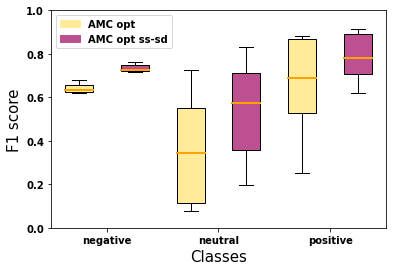

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc, rcParams
import matplotlib.patches as mpatches

rc('font', weight='bold')

meanlineprops = dict(linestyle='--', linewidth=2.5, color='black')

fig1, ax1 = plt.subplots()
box1 = ax1.boxplot([mean_performances["negative"], 
                   mean_performances["neutral"],
                   mean_performances["positive"]],
                  showfliers=False,
                  positions = [1,3,5],
                  patch_artist=True)
box2 = ax1.boxplot([mean_performances_ft["negative"], 
                   mean_performances_ft["neutral"],
                   mean_performances_ft["positive"]],
                  showfliers=False,
                  positions = [2,4,6],
                  patch_artist=True)

ax1.set_xticks([1.5, 3.5, 5.5])
ax1.set_xticklabels(["negative", "neutral", "positive"], rotation=0)
ax1.set_ylabel("F1 score", fontsize=15)
ax1.set_xlabel("Classes", fontsize=15)

color1 = ['#ffeb99']
color2 = ['#bc5090']
for patch in box1['boxes']:
    patch.set_facecolor(color1[0])
for patch in box2['boxes']:
    patch.set_facecolor(color2[0])
for line in box1['medians']:
    line.set_linewidth(2)
    line.set_color("#ffa200")
for line in box2['medians']:
    line.set_linewidth(2)
    line.set_color("#ffa200")
    
a_patch = mpatches.Patch(color='#ffeb99', label='AMC opt')
b_patch = mpatches.Patch(color='#bc5090', label='AMC opt ss-sd')
ax1.legend(handles=[a_patch, b_patch])
ax1.set_ylim(0,1)

plt.savefig("./f1_distribution_per_class.pdf")
fig1.show()